In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import pandas as pd
import time 
import os
import pathlib
import datetime
import matplotlib.pyplot as plt
from torch import optim
from torch.autograd import Variable 
from pathlib import Path
from random import randint
import torch.nn as nn
import torch.nn.functional as F
from statistics import mode, mean
import matplotlib.pyplot as plt

directory = r'C:\Users\savva\OneDrive\Desktop\npy'
patient_ID = ['2zbyXzYNKPwiPtjaA2L64o.npy','3hY7Mp7u9YPo1xMARSxLhc.npy','4h1dAuzg9rdrhyojwxUS26.npy']
colums1 = ['time','end time']
colums2 = ['time','end time','Reading 1']
colums3 = ['time','end time','Reading 1','Reading 2']
door_key = 0
switch = 0
pir_key = 0
hidden_size = 2
hidden_size
def Data_Loader(patient):
    sensors_lst = []
    column_names = []
    for subdirectory in os.scandir(directory):
        lock = False
        for patients in os.scandir(subdirectory):
            if str(pathlib.Path(patients)).endswith(patient_ID[0]):
                if lock == False:
                    column_names.append(str(os.path.basename(subdirectory)))
                    lock == True                                              
                sensors = np.load(pathlib.Path(patients))
                sensors_lst.append(sensors)
    sensors_pd = pd.DataFrame([sensors_lst],columns=column_names)
    dataframe_lst = []
    df = pd.DataFrame()
    sensor_num = 2
    Sensor_ID = column_names[sensor_num]
    print(Sensor_ID)
    for i in range(len(sensors_pd[Sensor_ID].loc[0])):
        dataframe_lst.append(sensors_pd[Sensor_ID].loc[0][i])
    if len(sensors_pd[Sensor_ID].loc[0][0]) == 2: 
        df = pd.DataFrame(dataframe_lst,columns = colums1)
        df = df.drop("end time", axis=1)
    elif len(sensors_pd[Sensor_ID].loc[0][0]) == 3:    
        df = pd.DataFrame(dataframe_lst,columns = colums2)
        df = df.drop("end time", axis=1)
    elif len(sensors_pd[Sensor_ID].loc[0][0]) == 4:    
        df = pd.DataFrame(dataframe_lst,columns = colums3)
        df = df.drop("end time", axis=1)
    df['labels'] = 0
    time = df['time']
    anomaly_lst = []
    col_name = df.columns
    col_len = len(df.columns)
    delta_t = []
    for i in range(0,len(df)-1):
        delta = abs(df.iloc[i,0] - df.iloc[i+1,0])
        delta_t.append(delta/100)
        i = i+1
    df['time delta'] = pd.Series(delta_t)

    delta_r1 = []
    for i in range(0,len(df)-1):
        delta = abs(df.iloc[i,1] - df.iloc[i+1,1])
        delta_r1.append(delta/100)
        i = i+1
    df['r1 delta'] = pd.Series(delta_r1)
    df.dropna(axis=1,inplace=False)
    return df[0:5000]

def create_anomaly(time,n,id):
    global pir_time
    global pir_key
    int = 0.0 # there are 20 locations
    if pir_key == 0:
        pir_time = time
        s = [str(integer) for integer in pir_time]
        a_string = "".join(s)
        pir_time = float(a_string)
        pir_key = 1
    if pir_key == 1:
        pir_time = 60.0
        return [int] + [0] + [pir_time] 

def spike_anomaly(time,n,id): # for ambient temp
    global pir_time
    global pir_key
    spikeint = 200.0 
    room_id = 15.0
    if pir_key == 0:
        pir_time = time
        s = [str(integer) for integer in pir_time]
        a_string = "".join(s)
        pir_time = float(a_string)
        pir_key = 1
    if pir_key == 1:
        pir_time = 60.0
        return [room_id] + [spikeint] + [0] + [pir_time] 

def variance_anomaly(time,n,id): # for ambient temp
    global pir_time
    global pir_key
    variancen = randint(0.0,200.0)
    variancen = variancen/10

    if pir_key == 0:
        pir_time = 0.0       
        pir_key = 1
    if pir_key == 1:
        pir_time = 0.0
        return [time] + [id] + [variancen] + [0] + [pir_time]+[40.0]


def anomaly_insertion(n,type,dataframe,id):
    df = dataframe
    anomaly_lst = []
    col_name = df.columns
    col_len = len(df.columns)
    start_t = min(dataframe['time'])
    end_t = max(dataframe['time'])

    for i in range(n):
        random_timestamp = random.randint(start_t,end_t)
        if type == 'create':
            zp_anomaly_lst = create_anomaly(random_timestamp,col_len,id)
        if type == 'spike':
            zp_anomaly_lst = spike_anomaly(random_timestamp,col_len,id)
        if type == 'variance':
            zp_anomaly_lst= variance_anomaly(random_timestamp,col_len,id)           
        anomaly_lst.append(zp_anomaly_lst)

    anomaly_df = pd.DataFrame(anomaly_lst,columns=col_name)
    concat_df = pd.concat([dataframe,anomaly_df],ignore_index=True)
    concat_df = concat_df.reset_index(drop=True)
    return  concat_df

dataT = Data_Loader(patient_ID[0])
dataV = Data_Loader(patient_ID[0])
dataV = dataV[0:80]

# dataV = anomaly_insertion(300,'create',df1,id = None)
#dataV = anomaly_insertion(1,'spike',df1,id = None)

dataV = anomaly_insertion(10,'variance',dataV,7)

dataT = dataT.astype('float32')
dataV = dataV.astype('float32')
timeT = dataT['time']
timeV = dataV['time']
dataV.sort_values('time')
initial_time = dataV['time'].loc[0]
size = len(dataV)
end_time = dataV['time'].loc[size-1]
dataT.drop('time', axis = 1, inplace = True)
dataV.drop('time', axis = 1, inplace = True)
train_data = dataT
valid_data = dataV

display(train_data)
display(valid_data)

X_trainD = train_data.loc[:, train_data.columns != 'labels']
X_valD = valid_data.loc[:, valid_data.columns != 'labels']
Y_trainD = train_data.loc[:,'labels']
Y_valD = valid_data.loc[:,'labels']

X_train = torch.tensor(X_trainD.values).float()
X_val =torch.tensor(X_valD.values).float()
Y_train = torch.tensor(Y_trainD.values).float()
Y_val = torch.tensor(Y_valD.values).float()

Y_tensor = Y_train.clone().detach()
new_shape = (len(Y_tensor), 1)
Y_train = Y_tensor.view(new_shape)

Y_tensor = Y_val.clone().detach()
new_shape = (len(Y_tensor), 1)
Y_val = Y_tensor.view(new_shape)

torch.flatten(X_train)
torch.flatten(Y_train)
torch.flatten(X_val)
torch.flatten(Y_val)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 512)        
        self.fc4 = nn.Linear(512, 2)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr = 3e-5)
criterion = nn.L1Loss()
batch_size = 1
n_epochs = 10
permutation_train = torch.randperm(X_train.size()[0])
permutation_val = torch.randperm(X_val.size()[0])


def Train_AD():
    for epoch in range(n_epochs):
        anomalies = []
        train_loss = []
        valid_loss = []
        accuracy = 0
        accuracy_history = []
        timer_plot = []
        for i in range(0,len(train_data), batch_size):
            optimizer.zero_grad()
            indices = permutation_train[i:i+batch_size]
            batch_x, batch_y = X_train[indices], Y_train[indices]
            outputs = model.forward(batch_x)
            loss = criterion(outputs,batch_y)
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            print(f"-> Training :   "+str(i)+"/"+str(X_train.size()[0]), end = "\r")  
        threshold = mean(train_loss)*2
        for a in range(0,X_val.size()[0], batch_size):
            start_time = time.time() 
            indicesV = permutation_val[a:a+batch_size]
            batch_x_val, batch_y_val = X_val[indicesV], Y_val[indicesV]
            output = model.forward(batch_x_val)
            pred = torch.max(output,1)[1]
            loss = criterion(output,batch_y_val)
            valid_loss.append(loss.item())
            if loss.item() >= threshold:
                anomalies.append(batch_x_val)
            time_elapsed = time.time() - start_time
            timer_plot.append(1000*time_elapsed/len(X_val))
            print(f"-> Testing :     "+str(a)+"/"+str(X_val.size()[0]), end = "\r")
        print(f"Finished                                                                                         ")
    return anomalies,train_loss,valid_loss
anomalies,train_loss,valid_loss = Train_AD()


In [85]:
print('total identified anomalies: '+str(len(anomalies)))
counter = 0
for i in range(len(anomalies)):
    x = anomalies[i].numpy()
    if x[0][3]==40.0:
        counter = counter+1

print('correctly identified anomalies: '+str(counter)+'/10')
print('false positives: '+ str(len(anomalies)-counter))


total identified anomalies: 17
correctly identified anomalies: 10/10
false positives: 7


In [70]:
print(pd.to_datetime(initial_time,utc = True,unit = 's'))
print(pd.to_datetime(end_time,utc = True,unit = 's'))
# Use this to check the time window of the validation set

2021-05-27 16:04:16+00:00
2021-05-27 17:29:36+00:00


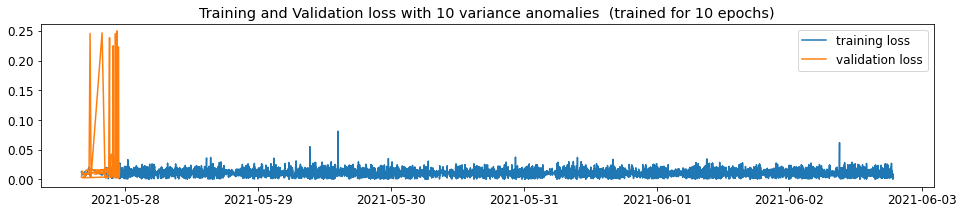

In [79]:

import pandas as pd

dates1 = pd.to_datetime(timeT, utc=True, unit='s')
dates2 = pd.to_datetime(timeV, utc=True, unit='s')

lstDateTime1 = dates1.to_list()
lstDateTime2 = dates2.to_list()
plt.figure(figsize=(16, 3))
plt.rcParams.update({'font.size': 12})
plt.title('Training and Validation loss with 10 variance anomalies  (trained for 10 epochs)')
plt.plot(lstDateTime1,train_loss,label = 'training loss')
plt.plot(lstDateTime2,valid_loss,label = 'validation loss')
plt.legend()
#plt.ylim([0,0.6])